### Analyse et comprehension des fichiers

In [4]:
import matplotlib.pyplot as plt
from read_data import *
from utils import *
from fasttext_utils import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [5]:
store_full_dataset_with_features(from_scratch=True, vectorize=True)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
217802
Starting data columns : ['author', 'hindex', 'text', 'nb_paper']
Add core number to data
Add pagerank to data
Add authority to data
Add clustering coef to data
Add eigenvector centrality to data
Add small class to data
Add neighborhood info to data


100%|██████████| 217801/217801 [00:55<00:00, 3935.78it/s]
Read 99M words
Number of words:  359997
Number of labels: 6
Progress: 100.0% words/sec/thread: 6841519 lr:  0.000000 avg.loss:  1.123567 ETA:   0h 0m 0s


Ending data columns : ['author', 'hindex', 'text', 'nb_paper', 'core_number', 'pagerank', 'authority', 'clustering_coef', 'eigenvector_centrality', 'modindx', 'hindex_lab', 'n_neighbors_dist_1', 'min_neighbors_dist_1', 'mean_neighbors_dist_1', 'max_neighbors_dist_1', 'n_neighbors_dist_2', 'min_neighbors_dist_2', 'mean_neighbors_dist_2', 'max_neighbors_dist_2', 'vector_coord_0', 'vector_coord_1']


In [6]:
train, test = get_processed_data()

/var/folders/57/vt366_td3_37y7bqh4rk7nqr0000gn/T/ipykernel_11641/1429269039.py:1: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  train, test = get_processed_data()


In [7]:
G, _, _ = get_graph()
# G = nx.convert_matrix.to_scipy_sparse_matrix(G)
percolation_centralities = nx.algorithms.centrality.eigenvector_centrality(G)

**distribution des données**

In [8]:
train,n_train = get_train_data()
test,n_test = get_test_data()

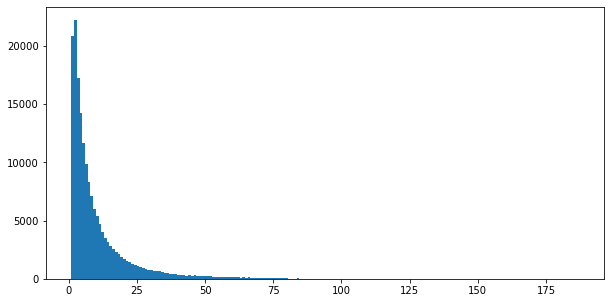

In [9]:
plt.figure(figsize=(10,5))
plt.hist(x=train['hindex'],bins=187);

**exploitation de model**

On est sur que le modèle applique softmax sur la représentation du mot. Nous ou choisit donc d'appliquer un autre régresseur

**Data for multiple regression model**

In [43]:
X_train, y_train, X_test, y_test = get_numpy_data(n=174241)

/var/folders/57/vt366_td3_37y7bqh4rk7nqr0000gn/T/ipykernel_11641/2692092469.py:1: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  X_train, y_train, X_test, y_test = get_numpy_data(n=174241)


In [11]:
X_train_norm, X_test_norm = normalize(X_train, X_test)

**Random forest**

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

**XG_BOOST**

In [ ]:
model_xg = XGBRegressor(learning_rate=0.01, max_depth=5, objective="reg:linear", subsample=0.7, n_estimators=500)
model_xg.fit(X_train,y_train)
mod_preds = model_xg.predict(X_test)
mean_squared_error(y_test,mod_preds)

**Neural Network**

In [ ]:

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model_nn = keras.Sequential()
model_nn.add(layers.Dense(64, kernel_initializer='uniform', input_shape=(10,)))
model_nn.add(layers.Activation('softmax'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

model_nn.compile(loss='mse', optimizer=optimizer)

model_nn.fit(X_train,y_train, epochs=10, batch_size=5)
mod_nn_preds = model_nn.predict(X_test)
print(len(mod_nn_preds))
mean_squared_error(y_test,mod_nn_preds)

### CATBOOST

In [9]:
from catboost import CatBoostRegressor
model_cat = CatBoostRegressor(verbose=False)
model_cat.fit(X_train, y_train)
mod_preds = model_cat.predict(X_test)
mean_squared_error(y_test,mod_preds)

48.3607035691917

In [10]:
from catboost import cv, Pool
params = {
    "loss_function":"RMSE"
}
cv_dataset = Pool(data=X_train, label=y_train)
cv(cv_dataset, params=params, verbose=False)

Training on fold [0/3]

bestTest = 6.943675114
bestIteration = 997

Training on fold [1/3]

bestTest = 7.025288715
bestIteration = 998

Training on fold [2/3]

bestTest = 7.019548334
bestIteration = 999



,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,15.769091,0.144416,15.768537,0.075459
1,1,15.453130,0.140421,15.452262,0.072936
2,2,15.139548,0.138511,15.138040,0.070778
3,3,14.839479,0.137209,14.837476,0.067895
4,4,14.554043,0.137167,14.550388,0.063020
...,...,...,...,...,...
995,995,6.996687,0.045852,6.574947,0.035201
996,996,6.996557,0.045878,6.574299,0.035081
997,997,6.996372,0.045731,6.573820,0.035280
998,998,6.996265,0.045465,6.573436,0.035340


**Light GBM**

In [46]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label = y_train)
params = {}
params['learning_rate'] = 0.33
params['num_iterations'] = 100
params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['sub_feature'] = 0.6
params['num_leaves'] = 50
params['min_data'] = 60
params['max_depth'] = 35
clf = lgb.train(params, d_train, 100)
y_pred=clf.predict(X_test)
mean_squared_error(y_test,y_pred)

/opt/homebrew/Caskroom/miniforge/base/envs/X/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3086
[LightGBM] [Info] Number of data points in the train set: 130680, number of used features: 16
[LightGBM] [Info] Start training from score 10.056688


48.45426553993418

**test linear regression**

In [ ]:
from sklearn import linear_model

reg = linear_model.TweedieRegressor().fit(X_train,y_train)

In [ ]:
reg_pred = reg.predict(X_test)

In [ ]:
mean_squared_error(y_test,reg_pred)

**test svm**

In [ ]:
from sklearn.svm import SVC

model_svm =SVC(kernel='sigmoid', C=2)

In [ ]:
model_svm.fit(X_train,y_train)

In [ ]:
svm_pred = model_svm.predict(X_test)

In [ ]:
mean_squared_error(y_test,svm_pred)

**Test CNN**

# Soumission

In [ ]:
from submit import submit
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
# from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(verbose=False)
model_forest = RandomForestRegressor()
model_xg = XGBRegressor(learning_rate=0.01, max_depth=5, objective="reg:linear", subsample=0.7, n_estimators=500)

submit(model_cat)

In [41]:
import lightgbm as lgb

X_train, y_train, X_test, y_test = get_submission_data()
X_train, X_test = normalize(X_train, X_test)


d_train = lgb.Dataset(X_train, label = y_train)
params = {}
params['learning_rate'] = 0.10
params['num_iterations'] = 500
params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['sub_feature'] = 0.6
params['num_leaves'] = 50
params['min_data'] = 60
params['max_depth'] = 35
clf = lgb.train(params, d_train, 100)
y_pred=clf.predict(X_test)


test, _ = get_test_data()
test["hindex"] = y_pred
submission = test[["author", "hindex"]]
submission.to_csv("../tmp/submission.csv", index=None)

/var/folders/57/vt366_td3_37y7bqh4rk7nqr0000gn/T/ipykernel_11641/3681237703.py:3: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  X_train, y_train, X_test, y_test = get_submission_data()
/opt/homebrew/Caskroom/miniforge/base/envs/X/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3113
[LightGBM] [Info] Number of data points in the train set: 174241, number of used features: 16
[LightGBM] [Info] Start training from score 10.087609
